A comparison between the initial behaviours of the original and the new implementation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

assert jax.config.read('jax_enable_x64')

Here we setup the parameters for the system.

In [2]:
# System parameters, used in both methods
m = 1.0
k = 100.0
ll = 1e-4 * np.sqrt(m * k)  # ll is $\lambda$ in the paper

# Simulation and Method parameters
dt = 0.1 * np.sqrt(m / k)
t_sample_count = 1000
tmax = t_sample_count * np.sqrt(m / k)
t0 = 0
t = t0 + dt * np.arange(0, t_sample_count + 1)
r = 0

# Initial conditions
q0 = [1.]
pi0 = [0.25 * dt * k]

Now the system dynamics

In [3]:
def lagrangian_f(q, qdot, t):
    return 0.5 * m * jnp.dot(qdot, qdot) - 0.5 * k * jnp.dot(q, q)

In [4]:
def create_original():
    from sympy import Symbol
    from original import slimplectic

    dho = slimplectic.GalerkinGaussLobatto('t', ['q'], ['v'])
    L = 0.5 * m * np.dot(dho.v, dho.v) - 0.5 * k * np.dot(dho.q, dho.q)
    # DHO:
    K = -ll * np.dot(dho.vp, dho.qm)
    # No damping:
    K_nd = Symbol('a')
    dho.discretize(L, K_nd, r, method='implicit', verbose=False)
    return dho


dho = create_original()

In [5]:
"""
We need to normalise the format of the results to compare them and be able to plot them nicely.
"""


def format_original(original_results):
    return np.vstack([
        np.array(original_results[0]),
        np.array(original_results[1])
    ]).T


def format_jax(jax_results):
    return np.vstack(
        [
            np.array(jax_results[0]),
            np.array(jax_results[1])
        ],
    ).T

## Original Implementation

In [6]:
original_results = dho.integrate(q0, pi0, t)
original_results_fmt = format_original(original_results)
original_results_fmt

t,qi_sol_0,qi_sol_1,
0.0,
0.010000000000000002,
0.020000000000000004,
0.030000000000000006,
0.04000000000000001,
0.05000000000000001,
0.06000000000000001,
0.07,
0.08000000000000002,
0.09000000000000002,
0.10000000000000002,
0.11000000000000001,
0.12000000000000002,
0.13000000000000003,
0.14,
0.15000000000000002,
0.16000000000000003,
0.17000000000000004,
0.18000000000000005,
0.19000000000000003,
0.20000000000000004,
0.21000000000000005,
0.22000000000000003,
0.23000000000000004,
0.24000000000000005,
0.25000000000000006,
0.26000000000000006,
0.2700000000000001,
0.28,
0.29000000000000004,
0.30000000000000004,
0.31000000000000005,
0.32000000000000006,
0.33000000000000007,
0.3400000000000001,
0.3500000000000001,
0.3600000000000001,
0.37000000000000005,
0.38000000000000006,
0.39000000000000007,
0.4000000000000001,
0.4100000000000001,
0.4200000000000001,
0.4300000000000001,
0.44000000000000006,
0.45000000000000007,
0.4600000000000001,
0.4700000000000001,
0.4800000000000001,
0.4900000000000001,

array([[ 1.        ,  0.25      ],
       [ 0.9975    , -0.74875   ],
       [ 0.985025  , -1.7400125 ],
       ...,
       [ 0.7557488 ,  6.5452016 ],
       [ 0.81742207,  5.75861617],
       [ 0.87092112,  4.91444457]])

## JAX Implementation

In [7]:
from slimpletic import Solver

solver = Solver(r=r, dt=dt, lagrangian=lagrangian_f)

jax_results = solver.integrate(jnp.array(q0), jnp.array(pi0), t0, t_sample_count)

In [20]:
pi_prediction = jax.vmap(
    fun=solver.compute_pi_next,
)(original_results[2][0:-1,:],t)

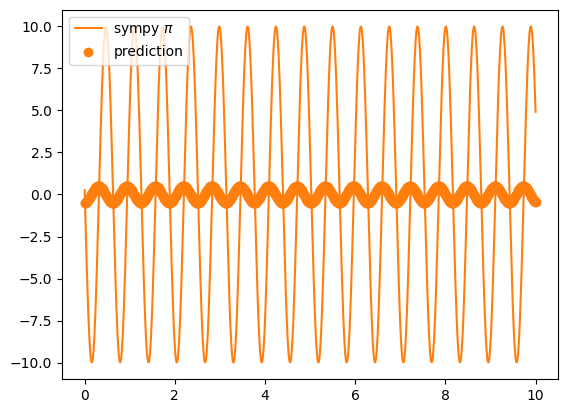

In [26]:
# plt.plot(t, original_results_fmt[:, 0], label='sympy q', color='C0')
# plt.scatter(t, jax_results[0].reshape(1, -1), label='jax q', color='C0', marker='x')
plt.plot(t, original_results_fmt[:, 1], label='sympy $\pi$', color='C1', )
# plt.scatter(t, jax_results[1].reshape(1, -1), label='jax $\pi$', color='C1', marker='x')
plt.scatter(t, pi_prediction, label='prediction', color='C1', )
plt.legend()